In [1]:
import pandas as pd
import numpy as np
from numpy import savetxt
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
import itertools

In [2]:
import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Main imports
from econml.ortho_forest import DMLOrthoForest, DROrthoForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from econml.metalearners import TLearner

from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter
import graphviz

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression
import matplotlib.pyplot as plt

%matplotlib inline

# A few more imports
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

In [4]:
case_id_col = "Case ID"
activity_col = "Activity"
resource_col = "org:resource"
timestamp_col = "time:timestamp"

treatment = 'treatment'
outcome = 'duration'

In [5]:
dynamic_cat_cols = ["Activity", 'org:resource', 'Action', 'EventOrigin', 'lifecycle:transition']
static_cat_cols = ['ApplicationType', 'LoanGoal']
dynamic_num_cols = ['FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', "open_cases", "month", "weekday", "hour"]
static_num_cols = ['RequestedAmount', 'CreditScore', 'timesincefirstcase', 'duration', 'treatment']

In [7]:
df2 = pd.read_csv('data_17_incompleteFiles.csv')

In [8]:
# Prepare data for time of activity treatment
train, test = train_test_split(df2, test_size=0.2, shuffle=False)
train, valid = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment, case_id_col], axis=1)
features_test = valid.drop([outcome, treatment, case_id_col], axis=1)


cat_confound_cols = ['LoanGoal', 'ApplicationType']
num_confound_cols = features.columns.difference(cat_confound_cols)

cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['RequestedAmount', 'CreditScore']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()
W1 = scaler.fit_transform(features[[c for c in num_confound_cols]].to_numpy())
W2 = pd.get_dummies(features[cat_confound_cols]).to_numpy()
W = np.concatenate([W1, W2], axis=1)
X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

X1_test = scaler.fit_transform(features_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(features_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

In [9]:
N_trees = [200]
Min_leaf_size = [20]
Max_depth = [30]
Subsample_ratio = [0.4]
Lambda_reg = [0.01]

In [10]:
# preparing the test set
f_test = test.drop([outcome, treatment], axis=1)
X1_test = scaler.fit_transform(f_test[[c for c in num_hetero_cols]].to_numpy())
X2_test = pd.get_dummies(f_test[cat_hetero_cols]).to_numpy()
X_test = np.concatenate([X1_test, X2_test], axis=1)

    
for i in itertools.product(N_trees, Min_leaf_size, Max_depth, Subsample_ratio, Lambda_reg):
    print(i)
    n_trees = i[0]
    min_leaf_size = i[1]
    max_depth = i[2]
    subsample_ratio = i[3]
    lambda_reg = i[4]
    est = DMLOrthoForest(
        n_trees=n_trees, min_leaf_size=min_leaf_size, max_depth=max_depth, 
        subsample_ratio=subsample_ratio, discrete_treatment=True,
        model_T=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'),
        model_Y=Lasso(alpha=lambda_reg),
        model_T_final=LogisticRegression(C=1/(X.shape[0]*lambda_reg), penalty='l1', solver='saga'), 
        model_Y_final=WeightedLasso(alpha=lambda_reg),
        random_state=106
       )
    
    ortho_model = est.fit(Y, T, X, W)
    batches = np.array_split(X_test, X_test.shape[0] / 100)
    treatment_effects = est.const_marginal_effect(batches[0])
    ii = 0
    for batch in batches[1:]:
#         print(ii)
        estimates = est.const_marginal_effect(batch)
        treatment_effects = np.append(treatment_effects, estimates)
        ii += 1
    df_results = test
    df_results['Treatment Effects'] = treatment_effects

(200, 20, 30, 0.4, 0.01)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 102 | elapsed:   14.5s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 102 | elapsed:    8.7s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done 102 out of 102 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of 102 | 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 101 | elapsed:    9.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 101 | elapsed:    9.1s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 101 | elapsed:    9.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of 101 | elapsed:    9.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done 101 out of 101 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parall

In [11]:
train, test = train_test_split(df2, test_size=0.2, shuffle=False)
train = train[train[treatment]==0]
# train, valid = train_test_split(train, test_size=0.2, shuffle=False)
features = train.drop([outcome, treatment, case_id_col], axis=1)
features_test = valid.drop([outcome, treatment, case_id_col], axis=1)


cat_confound_cols = ['LoanGoal', 'ApplicationType']
num_confound_cols = features.columns.difference(cat_confound_cols)

cat_hetero_cols = ['LoanGoal', 'ApplicationType']
num_hetero_cols = features.columns.difference(cat_hetero_cols)
#num_hetero_cols = ['RequestedAmount', 'CreditScore']

Y = train[outcome].to_numpy()
T = train[treatment].to_numpy()
scaler = StandardScaler()

X1 = scaler.fit_transform(features[[c for c in num_hetero_cols]].to_numpy())
X2 = pd.get_dummies(features[cat_hetero_cols]).to_numpy()
X = np.concatenate([X1, X2], axis=1)

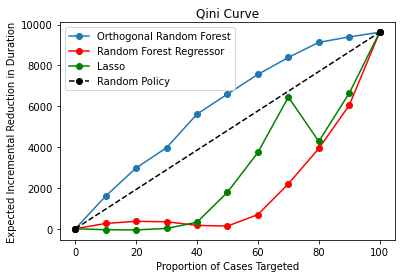

In [13]:
# df_results = test
# df_results['Treatment Effects'] = treatment_effects


pred = Lasso()
pred.fit(X, Y)

pred2 = RandomForestRegressor()
pred2.fit(X, Y)

yhat_test = pred.predict(X_test)
df_results['predictions_lasso'] = yhat_test

yhat_test2 = pred2.predict(X_test)
df_results['predictions_RF'] = yhat_test2

net_value = [0]
net_value2 = [0]
net_value3 = [0]

percentages = [10,20,30,40,50,60,70,80,90,100]

for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nsmallest(num,'Treatment Effects')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value.append(reduction)


for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nlargest(num,'predictions_lasso')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value2.append(reduction)
    
for n in percentages:
    num = int(len(df_results)*(n/100))
    top_n = df_results.nlargest(num,'predictions_RF')
    n_treated = top_n[top_n['treatment']==1].shape[0]
    n_control = top_n[top_n['treatment']==0].shape[0]
    scale_factor = n_treated/n_control

    treated = top_n[top_n['treatment']==1]['duration'].sum()
    control = top_n[top_n['treatment']==0]['duration'].sum()

    reduction = (scale_factor*control) - treated 
    net_value3.append(reduction)


plt.plot([0]+percentages, net_value, label="Orthogonal Random Forest", marker="o")
plt.plot([0]+percentages, net_value3, label="Random Forest Regressor", marker="o", color='Red')
plt.plot([0]+percentages, net_value2, label="Lasso", marker="o", color='Green')
plt.plot([0,percentages[9]], [0,net_value[10]], label="Random Policy",  marker="o", color='Black',
         linestyle='dashed')
plt.xlabel('Proportion of Cases Targeted')
plt.ylabel('Expected Incremental Reduction in Duration')
plt.legend(loc='best')
plt.title('Qini Curve')

plt.savefig('Results/bpic_17_qini_withBaseline', format='png', dpi=300)


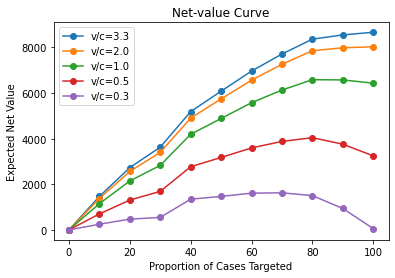

In [14]:
value = [1]
cost = [3,1,2,0.5,0.2]
cost = [0.3,0.5,1,2,3]

percentages = [10,20,30,40,50,60,70,80,90,100]

for i in itertools.product(value, cost):
    net_value = [0]
    v = i[0]
    c = i[1]
    for n in percentages:
        num = int(len(df_results)*(n/100))
        top_n = df_results.nsmallest(num,'Treatment Effects')
        n_treated = top_n[top_n['treatment']==1].shape[0]
        n_control = top_n[top_n['treatment']==0].shape[0]
        scale_factor = n_treated/n_control

        treated = top_n[top_n['treatment']==1]['duration'].sum()
        control = top_n[top_n['treatment']==0]['duration'].sum()

        reduction = (scale_factor*control) - treated
        net_val = (reduction*v) - (n_treated*c) 
        net_value.append(net_val)
    #     net_value.append(reduction)

    # plt.figure(figsize=(10, 4))
    # plt.subplot(1, 2, 1)
    plt.plot([0]+percentages, net_value, label="v/c=%s"%str(round(v/c,1)), marker="o")
#     plt.plot([0,percentages[9]], [0,net_value[10]], label="'Random Policy",  marker="o", color='Gray',
#              linestyle='dashed')
    plt.xlabel('Proportion of Cases Targeted')
    plt.ylabel('Expected Net Value')
    plt.legend(loc='best')
    plt.title('Net-value Curve')

plt.savefig('Results/bpic_17_netValue.png', format='png', dpi=300)